In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [154]:
df=pd.read_csv('income.csv')

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30000 non-null  int64 
 1   sex             30000 non-null  object
 2   education       30000 non-null  object
 3   education-num   30000 non-null  int64 
 4   marital-status  30000 non-null  object
 5   workclass       30000 non-null  object
 6   occupation      30000 non-null  object
 7   hours-per-week  30000 non-null  int64 
 8   income          30000 non-null  object
 9   label           30000 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 2.3+ MB


In [156]:
conts=['age','education-num','hours-per-week']
cats=['sex','education','marital-status','workclass','occupation']

In [157]:
for col in cats:
    df[col]=df[col].astype('category')

In [158]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             30000 non-null  int64   
 1   sex             30000 non-null  category
 2   education       30000 non-null  category
 3   education-num   30000 non-null  int64   
 4   marital-status  30000 non-null  category
 5   workclass       30000 non-null  category
 6   occupation      30000 non-null  category
 7   hours-per-week  30000 non-null  int64   
 8   income          30000 non-null  object  
 9   label           30000 non-null  int64   
dtypes: category(5), int64(4), object(1)
memory usage: 1.3+ MB


In [159]:
df['sex'].cat.categories

Index(['Female', 'Male'], dtype='object')

In [160]:
sex=df['sex'].cat.codes
education=df['education'].cat.codes
mart=df['marital-status'].cat.codes
work=df['workclass'].cat.codes
occup=df['occupation'].cat.codes

In [161]:
cat=np.stack([sex,education,mart,work,occup],axis=1)

In [162]:
cat

array([[ 1, 10,  3,  2,  1],
       [ 1, 11,  1,  1,  2],
       [ 1, 10,  0,  3,  7],
       ...,
       [ 1, 12,  1,  2,  7],
       [ 0, 13,  3,  2,  0],
       [ 1,  6,  1,  3,  2]], dtype=int8)

In [163]:
cat=torch.tensor(cat,dtype=torch.int)

In [164]:
cat

tensor([[ 1, 10,  3,  2,  1],
        [ 1, 11,  1,  1,  2],
        [ 1, 10,  0,  3,  7],
        ...,
        [ 1, 12,  1,  2,  7],
        [ 0, 13,  3,  2,  0],
        [ 1,  6,  1,  3,  2]], dtype=torch.int32)

In [165]:
conts=np.stack([df[cols] for cols in conts],axis=1)

In [166]:
conts

array([[27,  9, 40],
       [47, 14, 50],
       [59,  9, 20],
       ...,
       [47, 15, 55],
       [32, 10, 40],
       [33, 12, 60]], dtype=int64)

In [167]:
conts=torch.tensor(conts,dtype=torch.float)

In [168]:
conts

tensor([[27.,  9., 40.],
        [47., 14., 50.],
        [59.,  9., 20.],
        ...,
        [47., 15., 55.],
        [32., 10., 40.],
        [33., 12., 60.]])

In [169]:
y_col=df['label'].values

In [170]:
y_col=torch.tensor(y_col)

In [171]:
y_col

tensor([0, 1, 0,  ..., 1, 0, 1])

In [172]:
embed_szs=[(len(df[cols].cat.categories),min(50,len(df[cols].cat.categories)//2)) for cols in cats]

In [173]:
embed_szs

[(2, 1), (14, 7), (6, 3), (5, 2), (12, 6)]

In [174]:
class Tabular_Model(nn.Module):
    def __init__(self,conts,out,layers,emb,p=0.5):
        super().__init__()
        self.embed=nn.ModuleList([nn.Embedding(ni,nf) for (ni,nf) in emb])
        self.batc=nn.BatchNorm1d(conts)
        self.drop=nn.Dropout(p)
        ci=sum([nf for (ni,nf) in emb])
        n_cont=conts+ci
        layer_list=[]
        for i in layers:
            layer_list.append(nn.Linear(n_cont,i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_cont=i
        layer_list.append(nn.Linear(layers[-1],out))
        self.layers=nn.Sequential(*layer_list)
    
    def forward(self,x_cat,x_cont):
        Embeddings=[]
        for i,e in enumerate(self.embed):
            Embeddings.append(e(x_cat[:,i]))
        x_cat=torch.cat(Embeddings,1)
        x_cat=self.drop(x_cat)
        
        x_cont=self.batc(x_cont)
        x=torch.cat([x_cont,x_cat],1)
        x=self.layers(x)
        return x
    

In [175]:
model=Tabular_Model(conts.shape[1],2,[200,100,50],embed_szs,p=0.4)

In [176]:
model

Tabular_Model(
  (embed): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 2)
    (4): Embedding(12, 6)
  )
  (batc): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.4, inplace=False)
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=50, bias=True)
    (9): ReLU(inplace=True)
    (10): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_fe

In [177]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [178]:
batch_size=30000
test_size=int(0.2*30000)
cat_train=cat[:batch_size-test_size]
cat_test=cat[batch_size-test_size:batch_size]
con_train=conts[:batch_size-test_size]
con_test=conts[batch_size-test_size:batch_size]
y_train=y_col[:batch_size-test_size]
y_test=y_col[batch_size-test_size:batch_size]

In [179]:
y_train.shape

torch.Size([24000])

In [180]:
losses=[]
epochs=300
for i in range(epochs):
    i+=1
    y_pred=model(cat_train,con_train)
    loss=criterion(y_pred,y_train)
  

    losses.append(loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

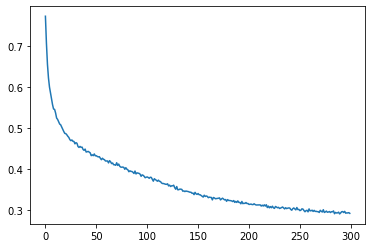

In [181]:
plt.plot(range(epochs),losses)

In [183]:
with torch.no_grad():
    y_pred=model(cat_test,con_test)
    loss=criterion(y_pred,y_test)

In [184]:
loss

tensor(0.3030)